In [32]:
# Author: University of Washington Center for Human Rights
# Date: 2019-04-29
# License: GPL 3.0 or greater
# Path: ice-air/analyze/note/nationality.ipynb

import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

This notebook and its outputs are of an exploratory nature only and do not necessarily reflect the final findings of UWCHR as published in the report ["Hidden in Plain Sight: ICE Air and the Machinery of Mass Deportation"](https://jsis.washington.edu/humanrights/2019/04/23/ice-air/).

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [33]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732625 entries, 0 to 1732624
Data columns (total 48 columns):
Status                          category
Sex                             category
Convictions                     category
GangMember                      category
ClassLvl                        float32
Age                             float32
MissionDate                     datetime64[ns]
MissionNumber                   uint32
PULOC                           category
DropLoc                         category
StrikeFromList                  float32
ReasonStruck                    category
R-T                             category
Code                            category
CountryOfCitizenship            category
Juvenile                        bool
MissionWeek                     uint8
MissionQuarter                  uint8
MissionYear                     uint16
MissionMonth                    uint8
Criminality                     category
FamilyUnitFlag                  float32


# By country of citizenship

Define target nationality, check if represented in dataset.

In [34]:
nationality = 'EL SALVADOR'

In [35]:
errormsg = f'{nationality} not represented in dataset'
assert nationality.upper() in df['CountryOfCitizenship'].str.upper().unique(), errormsg

Create DataFrames for removals and transfers, removing duplicate `AlienMasterID` values.

In [36]:
removal_df = df[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')
transfer_df = df[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')

Ranking total removals by `CountryOfCitizenship`. Should implement other comparative statistics.

In [37]:
all_nationalities = removal_df.groupby(['CountryOfCitizenship'])['AlienMasterID'].nunique()
all_nationalities = all_nationalities.sort_values(ascending=False)
all_nationalities = all_nationalities.reset_index().reset_index()
all_nationalities['Rank'] = all_nationalities['index'] + 1
all_nationalities.drop('index', axis=1, inplace=True)
target = all_nationalities.loc[all_nationalities['CountryOfCitizenship'] == nationality].reset_index()
print(f"{nationality}: ranked {target.loc[0, 'Rank']} of {len(all_nationalities)} countries, with {target.loc[0, 'AlienMasterID']} total removals.")
# Probably a better way to do this than with index

EL SALVADOR: ranked 4 of 204 countries, with 157538 total removals.


Create a DataFrame filtered for target nationality only.

In [38]:
nationality_df = df[df['CountryOfCitizenship'] == nationality.upper()]

In [39]:
# Top pickup airports (removals and transfers)
nationality_df['air_AirportName'].value_counts().head(10)

Laredo International Airport                            40481
Alexandria International Airport                        36956
Phoenix-Mesa-Gateway Airport                            28242
San Antonio International Airport                       24257
George Bush Intercontinental Houston Airport            19670
Brownsville South Padre Island International Airport    19298
Valley International Airport                            13233
Harrisburg International Airport                        12390
El Paso International Airport                           11558
Columbus Metropolitan Airport                            7831
Name: air_AirportName, dtype: int64

In [40]:
# Top dropoff airports (removals and transfers)
nationality_df['air2_AirportName'].value_counts().head(10)

El Salvador International Airport                 157409
Alexandria International Airport                   32974
Phoenix-Mesa-Gateway Airport                       20382
El Paso International Airport                       6905
Miami International Airport                         5711
Newark Liberty International Airport                4103
Harrisburg International Airport                    3955
Boeing Field King County International Airport      3430
Columbus Metropolitan Airport                       2779
Gary Chicago International Airport                  2335
Name: air2_AirportName, dtype: int64

In [41]:
nationality_df.set_index('MissionDate', inplace=True)

In [42]:
(nationality_df[nationality_df['R-T'] == 'R']['air2_Country'].value_counts() / len(nationality_df[nationality_df['R-T'] == 'R'])).head()

El Salvador              0.999181
USA                      0.000806
Honduras                 0.000013
Republic of the Congo    0.000000
Ethiopia                 0.000000
Name: air2_Country, dtype: float64

In [43]:
g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'PULOC', 'DropLoc'])
# g = nationality_df.groupby(['CountryOfCitizenship', 'MissionDate', 'R-T', 'Juvenile', 'NonCriminal'])

In [44]:
# We can improve construction of this table, look at other notebooks
table = g['AlienMasterID'].nunique().reset_index(name='AlienMasterIDCount')
table['MissionIDCount'] = g['MissionID'].nunique().reset_index(name='MissionIDCount')['MissionIDCount']
table['JuvenileCount'] = g['Juvenile'].sum().reset_index(name='JuvenileCount')['JuvenileCount']
table['JuvPercent'] = table['JuvenileCount'] / table['AlienMasterIDCount']
table['NCCount'] = g['NonCriminal'].sum().reset_index(name='NCCount')['NCCount']
table['NCPercent'] = table['NCCount'] / table['AlienMasterIDCount'] * 100

In [45]:
removals = table[table['R-T'] == 'R'].copy()
transfers = table[table['R-T'] == 'T'].copy()

In [46]:
removals.set_index('MissionDate', inplace=True)
transfers.set_index('MissionDate', inplace=True)

In [47]:
# Total removals
removals['AlienMasterIDCount'].sum()

157538

In [48]:
# Total removal missions
removals['MissionIDCount'].sum()

2524

In [49]:
# Total transfers
transfers['AlienMasterIDCount'].sum()

99163

In [50]:
weekly_removals = removals['AlienMasterIDCount'].resample('W').sum()
weekly_transfers = transfers['AlienMasterIDCount'].resample('W').sum()
monthly_removals = removals['AlienMasterIDCount'].resample('M').sum()
monthly_transfers = transfers['AlienMasterIDCount'].resample('M').sum()
monthly_removal_flights = removals['MissionIDCount'].resample('M').sum()
monthly_transfers_flights = transfers['MissionIDCount'].resample('M').sum()
annual_removals = removals['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_transfers = transfers['AlienMasterIDCount'].resample('AS-OCT').sum()
annual_removal_flights = removals['MissionIDCount'].resample('AS-OCT').sum()
annual_transfer_flights = transfers['MissionIDCount'].resample('AS-OCT').sum()
annual_juvenile_removals = removals['JuvenileCount'].resample('AS-OCT').sum()

In [51]:
annual_removals.sum()

157538

In [52]:
annual_transfers

MissionDate
2010-10-01     7563
2011-10-01    10023
2012-10-01    16229
2013-10-01    26692
2014-10-01     9938
2015-10-01    11183
2016-10-01     8171
2017-10-01     7566
2018-10-01     1798
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [53]:
annual_juvenile_removals

MissionDate
2010-10-01    44.0
2011-10-01     8.0
2012-10-01     4.0
2013-10-01    41.0
2014-10-01    71.0
2015-10-01    77.0
2016-10-01    89.0
2017-10-01    36.0
2018-10-01     2.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [54]:
removals.reset_index(inplace=True, drop=False)
transfers.reset_index(inplace=True, drop=False)

In [55]:
removals.tail(20)

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
2483,2018-11-09,EL SALVADOR,R,KAEX,MSLP,52,1,0.0,0.000000,30.0,57.692308
2484,2018-11-14,EL SALVADOR,R,KAEX,MSLP,41,1,0.0,0.000000,19.0,46.341463
2485,2018-11-14,EL SALVADOR,R,KIWA,MSLP,71,1,0.0,0.000000,31.0,43.661972
2486,2018-11-15,EL SALVADOR,R,KLRD,MSLP,108,1,0.0,0.000000,71.0,65.740741
2487,2018-11-15,EL SALVADOR,R,KSAT,MSLP,27,1,1.0,0.037037,13.0,48.148148
2488,2018-11-16,EL SALVADOR,R,KAEX,MSLP,37,1,0.0,0.000000,12.0,32.432432
2489,2018-11-16,EL SALVADOR,R,KIAH,MSLP,50,1,0.0,0.000000,21.0,42.000000
2490,2018-11-21,EL SALVADOR,R,KAEX,MSLP,75,1,0.0,0.000000,40.0,53.333333
2491,2018-11-21,EL SALVADOR,R,KIWA,MSLP,34,1,0.0,0.000000,14.0,41.176471
2492,2018-11-21,EL SALVADOR,R,KLRD,MSLP,98,1,0.0,0.000000,81.0,82.653061


In [56]:
removals.to_csv(f'../output/{nationality}_removal_flights.csv')

In [57]:
transfers.head()

,MissionDate,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
0,2010-10-01,EL SALVADOR,T,KMCI,KAEX,1,1,0.0,0.0,0.0,0.0
1,2010-10-01,EL SALVADOR,T,KMDT,KAEX,30,1,0.0,0.0,0.0,0.0
2,2010-10-01,EL SALVADOR,T,KOAK,KIWA,2,1,0.0,0.0,0.0,0.0
3,2010-10-02,EL SALVADOR,T,KIWA,KBFI,8,1,0.0,0.0,0.0,0.0
4,2010-10-04,EL SALVADOR,T,KOAK,KIWA,2,1,0.0,0.0,0.0,0.0


In [58]:
# transfers.to_csv(f'../output/{nationality.lower()}_transfers.csv.gz', compression='gzip', sep='|', index=False)
# removals.to_csv(f'../output/{nationality.lower()}_repatriations.csv.gz', compression='gzip', sep='|', index=False)

In [59]:
removals.set_index('MissionDate', inplace=True)

In [60]:
transfers.set_index('MissionDate', inplace=True)

In [61]:
r_cum = removals['AlienMasterIDCount'].cumsum()
t_cum = transfers['AlienMasterIDCount'].cumsum()

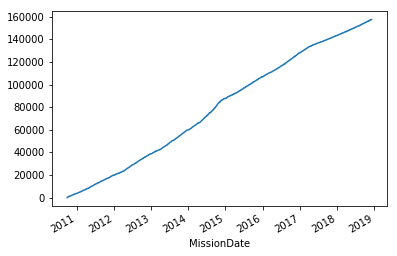

In [62]:
# Cumulative removals
# Based on density of removals, decide whether to use points or line
# r_cum.plot(style='o-')
r_cum.plot(style='-')

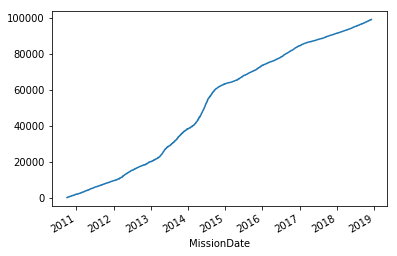

In [63]:
# Cumulative transfers
t_cum.plot()

In [64]:
g = nationality_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'R-T', 'air_AirportName', 'air2_AirportName', 'air2_Country'])[['AlienMasterID', 'MissionID']].nunique()
g.reset_index(inplace=True)
removal_dropoff_airports = g[g['R-T'] == 'R'].copy()
transfer_dropoff_airports = g[g['R-T'] == 'T'].copy()

In [65]:
removal_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)
transfer_dropoff_airports.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False], inplace=True)

In [66]:
removal_dropoff_airports.head()

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
7,2010-10-01,R,Phoenix-Mesa-Gateway Airport,El Salvador International Airport,El Salvador,4074,52
4,2010-10-01,R,George Bush Intercontinental Houston Airport,El Salvador International Airport,El Salvador,3707,58
0,2010-10-01,R,Alexandria International Airport,El Salvador International Airport,El Salvador,2603,41
9,2010-10-01,R,Valley International Airport,El Salvador International Airport,El Salvador,1755,22
8,2010-10-01,R,San Antonio International Airport,El Salvador International Airport,El Salvador,1416,25


In [67]:
transfer_dropoff_airports.head(10)

,MissionDate,R-T,air_AirportName,air2_AirportName,air2_Country,AlienMasterID,MissionID
31,2010-10-01,T,Harrisburg International Airport,Alexandria International Airport,USA,1423,59
85,2010-10-01,T,San Diego International Airport,Phoenix-Mesa-Gateway Airport,USA,1268,59
32,2010-10-01,T,Harrisburg International Airport,El Paso International Airport,USA,702,24
45,2010-10-01,T,Meadows Field,Phoenix-Mesa-Gateway Airport,USA,297,88
52,2010-10-01,T,Metropolitan Oakland International Airport,Phoenix-Mesa-Gateway Airport,USA,292,113
26,2010-10-01,T,El Paso International Airport,Phoenix-Mesa-Gateway Airport,USA,234,29
86,2010-10-01,T,Toledo Express Airport,Alexandria International Airport,USA,215,38
62,2010-10-01,T,Ontario International Airport,Phoenix-Mesa-Gateway Airport,USA,213,7
33,2010-10-01,T,Harrisburg International Airport,George Bush Intercontinental Houston Airport,USA,206,6
34,2010-10-01,T,Harrisburg International Airport,Miami International Airport,USA,177,5


In [68]:
# removal_dropoff_airports.to_csv(f'../output/{nationality}_repatriation_dropoff_airports.csv')
# transfer_dropoff_airports.to_csv(f'../output/{nationality}_transfer_dropoff_airports.csv')

In [69]:
removal_dropoff_airports = removal_dropoff_airports.set_index('MissionDate')

In [70]:
removal_sum = removal_dropoff_airports.groupby([pd.Grouper(freq='AS-OCT'), 'air2_AirportName'])[['AlienMasterID']].sum()

In [71]:
removal_sum.reset_index(inplace=True)
removal_sum = removal_sum.sort_values(by=['MissionDate', 'AlienMasterID'], ascending=[True, False])

In [72]:
removal_sum.set_index('MissionDate', inplace=True)

In [73]:
removal_sum = removal_sum.dropna()

In [74]:
top_5_df = pd.DataFrame()

for year in removal_sum.index.unique():
    temp = removal_sum.loc[f'{year}'][['air2_AirportName', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['air2_AirportName', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

/Users/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/Users/philneff/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [75]:
top_5_df

,0,air2_AirportName,AlienMasterID
air2_AirportName,El Salvador International Airport,NaN,NaN
AlienMasterID,15817,NaN,NaN
2010-10-01 00:00:00,NaN,ALL OTHERS,0.0
2011-10-01 00:00:00,NaN,El Salvador International Airport,18089.0
2011-10-01 00:00:00,NaN,Miami International Airport,8.0
2011-10-01 00:00:00,NaN,Laredo International Airport,6.0
2011-10-01 00:00:00,NaN,Alexandria International Airport,3.0
2011-10-01 00:00:00,NaN,Valley International Airport,1.0
2011-10-01 00:00:00,NaN,ALL OTHERS,0.0
air2_AirportName,El Salvador International Airport,NaN,NaN


In [76]:
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

AttributeError: 'Index' object has no attribute 'year'

In [ ]:
pivot = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='air2_AirportName',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

pivot = pivot.reindex(pivot.sum().sort_values(ascending=False).index, axis=1)
cols = list(pivot.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
pivot = pivot[cols]
pivot.columns = pivot.columns.str.title()
pivot.columns.name = 'Drop-off Airport'

In [ ]:
def airport_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax).legend(bbox_to_anchor=(1,1))

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100, bbox_inches='tight')
    return fig, ax

In [ ]:
airport_trend(pivot,
              title=f'{nationality.title()} \n Top Dropoff Airports for Removals',
              filename=f'{nationality}_top_removal_airports',
              ylabel='Total Removals',
              xlabel='Fiscal Year');

## Juveniles only

In [ ]:
juv_r_cum = removals['JuvenileCount'].cumsum()

In [ ]:
juv_r_cum.plot()

In [ ]:
removals.tail(20)

In [ ]:
removals['JuvPercent'].plot();

In [ ]:
removals['JuvenileCount'].plot();

In [ ]:
removals[removals['JuvPercent'] > .5]

In [ ]:
transfers['JuvenileCount'].value_counts()

In [ ]:
removals[removals['JuvenileCount'] > 20]

# KBFI only

In [130]:
airport = 'KBFI'

In [131]:
airport_removals = pd.concat([removals[removals['PULOC'] == airport], removals[removals['DropLoc'] == airport]])

In [132]:
airport_removals

,CountryOfCitizenship,R-T,PULOC,DropLoc,AlienMasterIDCount,MissionIDCount,JuvenileCount,JuvPercent,NCCount,NCPercent
MissionDate,,,,,,,,,,
2010-10-02,MEXICO,R,KBFI,KSAN,53,1,0.0,0.000000,0.0,0.000000
2010-10-06,MEXICO,R,KBFI,KHRL,18,1,0.0,0.000000,0.0,0.000000
2010-10-09,MEXICO,R,KBFI,KSAN,63,1,0.0,0.000000,0.0,0.000000
2010-10-13,MEXICO,R,KBFI,KHRL,27,1,0.0,0.000000,0.0,0.000000
2010-10-16,MEXICO,R,KBFI,KSAN,47,1,1.0,0.021277,0.0,0.000000
2010-10-23,MEXICO,R,KBFI,KSAN,99,1,0.0,0.000000,0.0,0.000000
2010-10-27,MEXICO,R,KBFI,KHRL,20,1,0.0,0.000000,0.0,0.000000
2010-10-30,MEXICO,R,KBFI,KSAN,92,1,0.0,0.000000,0.0,0.000000
2010-11-03,MEXICO,R,KBFI,KHRL,47,1,0.0,0.000000,0.0,0.000000


In [133]:
airport_transfers = pd.concat([transfers[transfers['PULOC'] == airport], transfers[transfers['DropLoc'] == airport]])

In [134]:
airport_transfers.to_csv(f'../output/{nationality}_transfers_tofrom_{airport}.csv')

In [135]:
airport_weekly_removals = airport_removals['AlienMasterIDCount'].resample('W').nunique()
airport_weekly_transfers = airport_transfers['AlienMasterIDCount'].resample('W').nunique()
airport_monthly_removals = airport_removals['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_transfers = airport_transfers['AlienMasterIDCount'].resample('M').nunique()
airport_monthly_removal_flights = airport_removals['MissionIDCount'].resample('M').nunique()
airport_monthly_transfers_flights = airport_transfers['MissionIDCount'].resample('M').nunique()
airport_annual_removals = airport_removals['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_transfers = airport_transfers['AlienMasterIDCount'].resample('AS-OCT').nunique()
airport_annual_removal_flights = airport_removals['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_transfer_flights = airport_transfers['MissionIDCount'].resample('AS-OCT').nunique()
airport_annual_juvenile_removals = airport_removals['JuvenileCount'].resample('AS-OCT').sum()
airport_annual_juvenile_transfers = airport_transfers['JuvenileCount'].resample('AS-OCT').sum()

In [136]:
airport_annual_removals

MissionDate
2010-10-01    62
2011-10-01    56
2012-10-01    40
2013-10-01    20
2014-10-01    15
2015-10-01    12
2016-10-01    14
2017-10-01    25
2018-10-01     8
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [137]:
airport_annual_removal_flights

MissionDate
2010-10-01    1
2011-10-01    1
2012-10-01    1
2013-10-01    1
2014-10-01    1
2015-10-01    1
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [138]:
airport_annual_juvenile_removals

MissionDate
2010-10-01    13.0
2011-10-01     8.0
2012-10-01     2.0
2013-10-01     0.0
2014-10-01     0.0
2015-10-01     0.0
2016-10-01     0.0
2017-10-01     4.0
2018-10-01     0.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

In [139]:
airport_annual_transfers

MissionDate
2010-10-01    14
2011-10-01    13
2012-10-01    32
2013-10-01    46
2014-10-01    34
2015-10-01    40
2016-10-01    40
2017-10-01    43
2018-10-01     7
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64

In [140]:
airport_annual_transfer_flights

MissionDate
2010-10-01    1
2011-10-01    1
2012-10-01    1
2013-10-01    1
2014-10-01    1
2015-10-01    1
2016-10-01    1
2017-10-01    1
2018-10-01    1
Freq: AS-OCT, Name: MissionIDCount, dtype: int64

In [141]:
airport_annual_juvenile_transfers

MissionDate
2010-10-01    0.0
2011-10-01    0.0
2012-10-01    0.0
2013-10-01    4.0
2014-10-01    0.0
2015-10-01    0.0
2016-10-01    0.0
2017-10-01    0.0
2018-10-01    0.0
Freq: AS-OCT, Name: JuvenileCount, dtype: float64

# Criminal status

 `Criminality` is not fully consistent with `Convictions`; especially in FY2010. 

In [142]:
removals['NCPercent']

MissionDate
2010-10-01      0.000000
2010-10-01      0.000000
2010-10-01      0.000000
2010-10-01      0.000000
2010-10-01      0.000000
2010-10-01      0.000000
2010-10-02      0.000000
2010-10-04      0.000000
2010-10-04      0.000000
2010-10-04      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-05      0.000000
2010-10-06      0.000000
2010-10-06      0.000000
2010-10-06      0.000000
2010-10-06      0.000000
2010-10-06      0.000000
2010-10-06      0.000000
2010-10-06      0.000000
2010-10-06      0.000000
2010-10-07      0.000000
2010-10-07      0.000000
                 ...    
2018-11-26     24.390244
2018-11-26     26.666667
2018-11-27     57.894737
2018-11-27     31.818182
2018-11-27     35.714286
2018-11-27     47.222222
2018-11-27     30.000000
2018-11-27     12.500000
2018-11-27   

In [143]:
removals['NCCount'].resample('AS-OCT').sum()

MissionDate
2010-10-01    44735.0
2011-10-01    54716.0
2012-10-01    39871.0
2013-10-01    16648.0
2014-10-01     7978.0
2015-10-01     5987.0
2016-10-01     8564.0
2017-10-01     8200.0
2018-10-01     1539.0
Freq: AS-OCT, Name: NCCount, dtype: float64

In [144]:
removals['AlienMasterIDCount'].resample('AS-OCT').sum()

MissionDate
2010-10-01    107781
2011-10-01    110763
2012-10-01     78651
2013-10-01     39278
2014-10-01     29461
2015-10-01     27082
2016-10-01     32967
2017-10-01     34738
2018-10-01      5387
Freq: AS-OCT, Name: AlienMasterIDCount, dtype: int64